1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?<br>
    ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?<br>
    CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.

3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?<br>
    CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.













In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH_BASE = './drive/MyDrive/ws_colab/'


Mounted at /content/drive


In [ ]:
import copy
import cv2
import numpy as np

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from PIL import Image
import matplotlib.pyplot as plt


In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


In [ ]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

In [ ]:
# 데이터 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    data_dir = PATH_BASE+'dataset/tf_dataset/', 
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
 
ds_train_normal = apply_normalize_on_dataset(ds_train)
ds_test_normal = apply_normalize_on_dataset(ds_test)
ds_info.features

In [ ]:
# ResNet50 모델 생성
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    # Imagenet 분류기  fully connected layer 제거
    include_top=False,    
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용
)

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
model_ = keras.Model(inputs=base_model.input, outputs=preds)

model_.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_model_ = model_.fit(
    ds_train_normal,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=5,
    validation_data=ds_test_normal,
    verbose=1,
    use_multiprocessing=True,
)
model_.summary()

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 103s 126ms/step - loss: 2.1792 - accuracy: 0.4493 - val_loss: 3.1022 - val_accuracy: 0.2484
Epoch 2/5
750/750 [==============================] - 93s 125ms/step - loss: 0.7867 - accuracy: 0.7828 - val_loss: 1.0875 - val_accuracy: 0.6774
Epoch 3/5
750/750 [==============================] - 93s 125ms/step - loss: 0.2635 - accuracy: 0.9406 - val_loss: 0.9824 - val_accuracy: 0.7052
Epoch 4/5
750/750 [==============================] - 94s 125ms/step - loss: 0.0701 - accuracy: 0.9924 - val_loss: 0.9031 - val_accuracy: 0.7303
Epoch 5/5
750/750 [==============================] - 94s 125ms/step - loss: 0.0231 - accuracy: 0.9994 - val_loss: 0.9118 - val_accuracy: 0.7348
Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []      

80


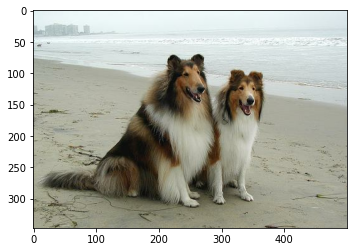

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

# CAM 구현하기

In [ ]:
def generate_cam(model, item):
    buf_item = copy.deepcopy(item)
    width = buf_item['image'].shape[1]
    height = buf_item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(buf_item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # GAP 이전 Convolution layer의 output
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 최종 weight activation
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
    
    # activation score를 normalize합니다.
    cam_image /= np.max(cam_image) 
    cam_image = cam_image.numpy()

    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image


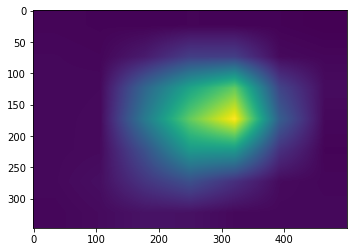

In [ ]:
image_cam = generate_cam(model_, item)
plt.imshow(image_cam)
plt.show()


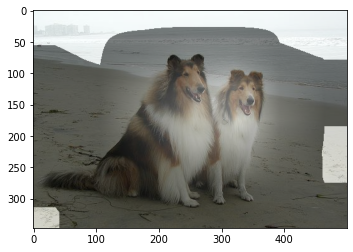

In [ ]:
img_ori = item['image'].astype(np.uint8)
img_cam_3ch = np.stack([image_cam*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(img_cam_3ch, img_ori)
plt.imshow(blended_image)


# Grad-CAM 구현하기
이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

바운딩 박스 구하기





In [ ]:
def generate_grad_cam(model, activation_layer, item):
    buf_item = copy.deepcopy(item)
    width = buf_item['image'].shape[1]
    height = buf_item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(buf_item)
    
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        loss = pred[:, class_idx]
        # 원하는 layer의 output을 얻습니다. 
        output = conv_output[0] 
        # 예측값에 따른 Layer의 gradient를 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] 

    # gradient의 GAP으로 class별 weight를 구합니다.
    weights = np.mean(grad_val, axis=(0, 1)) 
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


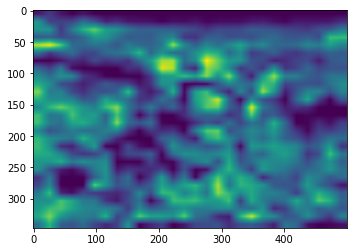

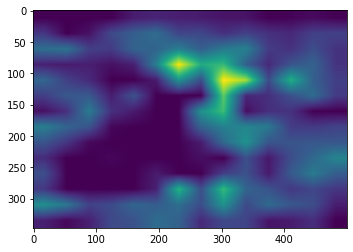

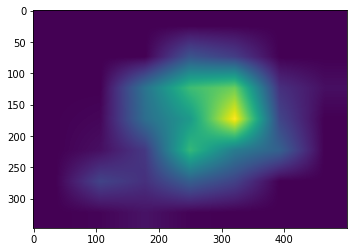

In [ ]:
image_cam_gard_3 = generate_grad_cam(model_, 'conv3_block3_out', item)
plt.imshow(image_cam_gard_3)
plt.show()

image_cam_gard_4 = generate_grad_cam(model_, 'conv4_block3_out', item)
plt.imshow(image_cam_gard_4)
plt.show()

image_cam_gard_5 = generate_grad_cam(model_, 'conv5_block3_out', item)
plt.imshow(image_cam_gard_5)
plt.show()


# 바운딩 박스 구하기

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


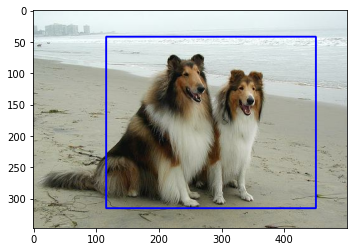

In [ ]:
rect_cam = get_bbox(image_cam)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

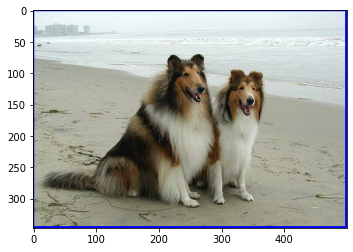

In [ ]:
rect_cam_grad_3 = get_bbox(image_cam_gard_3)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam_grad_3], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

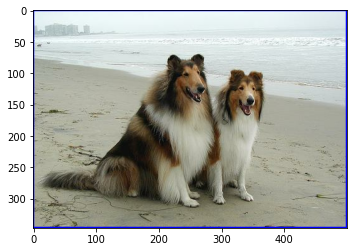

In [ ]:
rect_cam_grad_4 = get_bbox(image_cam_gard_4)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam_grad_4], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

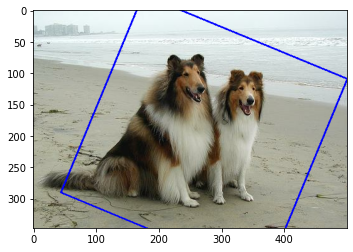

In [ ]:
rect_cam_grad_5 = get_bbox(image_cam_gard_5)
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect_cam_grad_5], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

IoU 구하기


In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [ ]:
pred_bbox = rect_to_minmax(rect_cam, item['image'])
pred_bbox

[0.12103746397694524, 0.232, 0.9077809798270894, 0.9]

In [ ]:
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3629432531939951